# Build BioMistral Medical RAG Chatbot using BioMistral Open Source LLM

In the notebook we will build a Medical Chatbot with BioMistral LLM and Medicare pdf file.


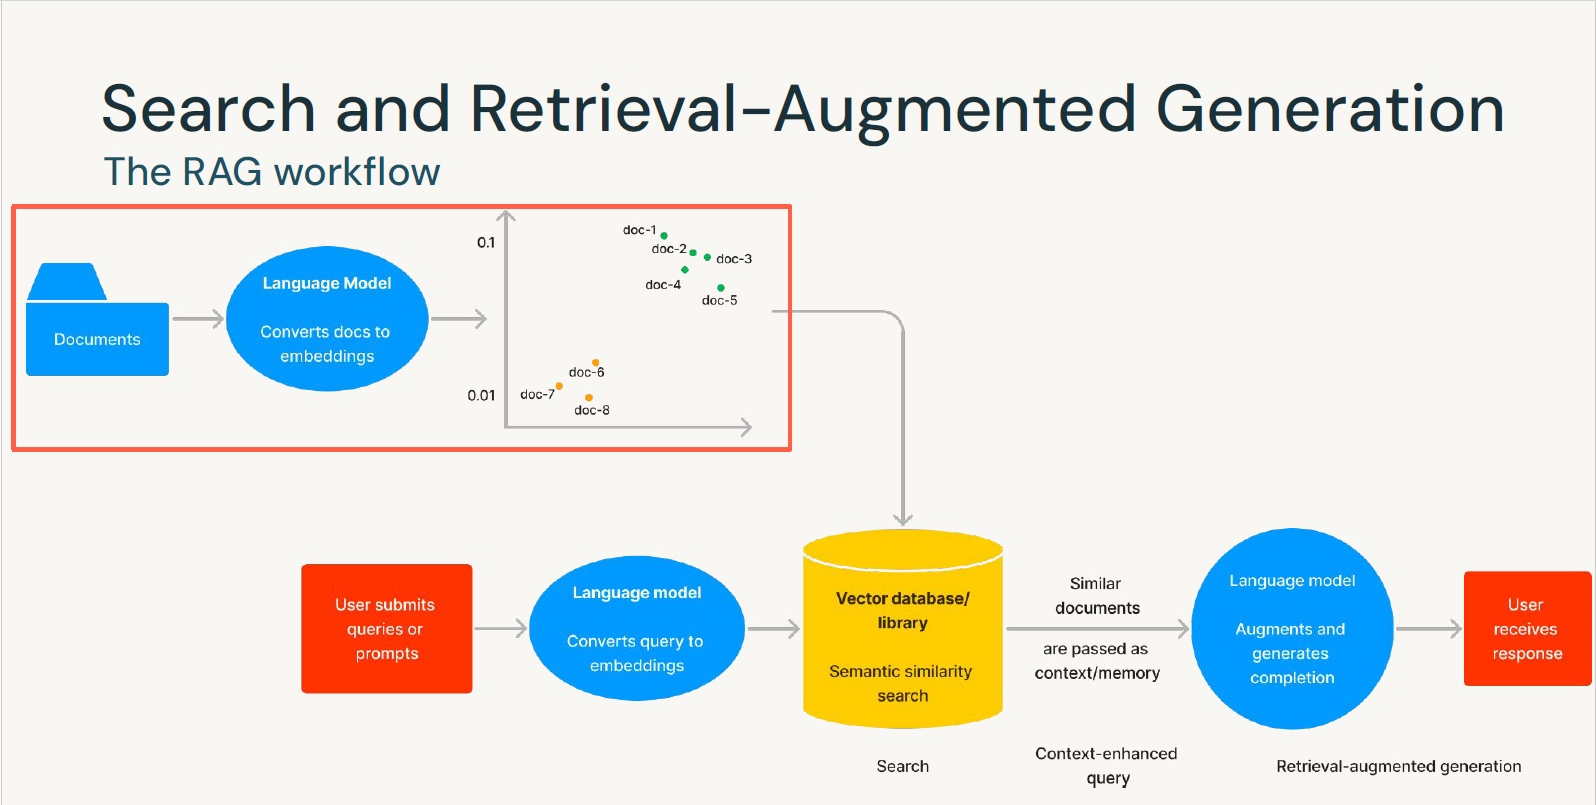

## Installation


In [ ]:
!pip install langchain sentence-transformers chromadb llama-cpp-python langchain_community pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 17.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.4 MB/s eta 0:00:00
     

## Import libraries

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import CharacterTextSplitter,RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma
from langchain_community.llms import LlamaCpp
from langchain.chains import RetrievalQA, LLMChain

In [ ]:
import pathlib
import textwrap
from IPython.display import display
from IPython.display import Markdown



def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
# Used to securely store your API key
from google.colab import userdata

## Setup HuggingFace Access Token

- Log in to [HuggingFace.co](https://huggingface.co/)
- Click on your profile icon at the top-right corner, then choose [“Settings.”](https://huggingface.co/settings/)
- In the left sidebar, navigate to [“Access Token”](https://huggingface.co/settings/tokens)
- Generate a new access token, assigning it the “write” role.


In [ ]:
# Or use `os.getenv('HUGGINGFACEHUB_API_TOKEN')` to fetch an environment variable.
import os
from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = userdata.get("HUGGINGFACEHUB_API_TOKEN")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = "HUGGINGFACEHUB_API_TOKEN"

## Import document


In [ ]:
loader = PyPDFDirectoryLoader("/content/sample_data/Medicare")
docs = loader.load()

In [ ]:
docs

[Document(page_content='2024Medicare\n& YouThe official U.S. government \nMedicare handbook \n', metadata={'source': '/content/sample_data/Medicare/Medicare.pdf', 'page': 0}),
 Document(page_content="What’s new & \nimportant?\nMedicare strives to improve access to affordable treatments to keep you healthy. \nCheck out what’s new this year to help you manage your health.\nSaving money on your prescription drugs\nIf you have Medicare drug coverage (Part D) and your drug costs are high enough to reach the catastrophic coverage phase, you don’t have to pay a copayment or coinsurance. Extra Help—a program that helps cover your Part D drug costs—expanded to cover more drug costs for certain people with limited resources and income. Go to pages 83  and 92. \nCoinsurance amounts for some Part B-covered drugs may be less if a prescription drug’s price increased higher than the rate of inflation. Go to page 40.\nLower costs for insulin and vaccines \nYour Medicare drug plan can't charge you more

## Text Splitting - Chunking

In [ ]:
chunk_size = 1500
overlap_percentage = 20  # Example overlap percentage
chunk_overlap = int(chunk_size * overlap_percentage / 100)
#splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, overlap=overlap)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
chunks = text_splitter.split_documents(docs)

In [ ]:
len(chunks)

271

In [ ]:
chunks[0]

Document(page_content='2024Medicare\n& YouThe official U.S. government \nMedicare handbook', metadata={'source': '/content/sample_data/Medicare/Medicare.pdf', 'page': 0})

In [ ]:
chunks[100]

Document(page_content='Opioid use disorder treatment services \nMedicare covers opioid use disorder treatment services in opioid treatment programs. The services include medication (like methadone, buprenorphine, naltrexone, and naloxone), substance use counseling, drug testing, individual and group therapy, intake activities, and periodic assessments. Medicare covers counseling, therapy services, and periodic assessments both in-person and, in certain circumstances, by virtual delivery (using audio and video communication technology, like your phone or a computer). Medicare also covers services given through opioid treatment program mobile units.\nMedicare pays doctors and other providers for office-based opioid use \ndisorder treatment, including management, care coordination, psychotherapy, and counseling activities. \nUnder Original Medicare, you won’t have to pay any copayments  for these \nservices if you get them from an opioid treatment program provider that’s \nenrolled in Med

## Embeddings

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Vector Store - FAISS or ChromaDB

In [ ]:
vectorstore = Chroma.from_documents(chunks, embeddings)

In [ ]:
vectorstore

In [ ]:
query = "What are the different types of Medicare Advantage Plans"
search = vectorstore.similarity_search(query)

In [ ]:
to_markdown(search[0].page_content)

> get most of your Part A and Part B coverage from your Medicare Advantage Plan, not Original Medicare. 
> What are the different types of Medicare Advantage Plans? 
>   * Health Maintenance Organization (HMO) Plan:  Go to page 66 . 
>   * HMO Point-of-Service (HMOPOS) Plan:  This HMO plan may allow you to 
> get some services out of network for a higher copayment  or coinsurance . 
> Go to page 66 .
>   * Medical Savings Account ( MSA) Plans: Go to page 67 .
>   * Preferred Provider Organization (PPO) Plan: Go to page 68 . 
>   * Private Fee-for-Service (PFFS) Plan:  Go to page 69. 
>   * Special Needs Plan (SNP): Go to page 70 . 
> What do Medicare Advantage Plans cover? 
> Medicare Advantage Plans provide all of your Part A and Part B benefits, except for  certain costs of clinical trials (clinical research studies), hospice 
> care, the cost of getting a kidney transplant (like expenses for a living kidney donor), and, for a temporary time, some new benefits that come from legislation or national coverage determinations. Contact your plan if you have questions about covered services.

## Retriever

In [ ]:
retriever = vectorstore.as_retriever(
    search_kwargs={'k':10}
)

In [ ]:
retriever.get_relevant_documents(query)

[Document(page_content='get most of your Part A and Part B coverage from your Medicare Advantage Plan, not Original Medicare. \nWhat are the different types of Medicare Advantage Plans? \n• Health Maintenance Organization (HMO) Plan:  Go to page 66 . \n• HMO Point-of-Service (HMOPOS) Plan:  This HMO plan may allow you to \nget some services out of network for a higher copayment  or coinsurance . \nGo to page 66 .\n• Medical Savings Account ( MSA) Plans: Go to page 67 .\n• Preferred Provider Organization (PPO) Plan: Go to page 68 . \n• Private Fee-for-Service (PFFS) Plan:  Go to page 69. \n• Special Needs Plan (SNP): Go to page 70 . \nWhat do Medicare Advantage Plans cover? \nMedicare Advantage Plans provide all of your Part A and Part B benefits, except for  certain costs of clinical trials (clinical research studies), hospice \ncare, the cost of getting a kidney transplant (like expenses for a living kidney donor), and, for a temporary time, some new benefits that come from legislatio

## Large Language Model - Open Source

In [ ]:
#connect to google drive
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
llm = LlamaCpp(
    model_path= "/content/drive/MyDrive/LLM_Model/BioMistral-7B.Q4_K_M.gguf",
    temperature=0.4,
    max_tokens=2048,
    top_p=1)

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from /content/drive/MyDrive/LLM_Model/BioMistral-7B.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = hub
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.atte

## RAG Chain


In [ ]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import ChatPromptTemplate

In [ ]:
template = """
<|context|>
You are an AI assistant that follows instruction extremely well.
Please be truthful and give direct answers
</s>
<|user|>
{query}
</s>
 <|assistant|>
"""

In [ ]:
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
rag_chain = (
    {"context": retriever,  "query": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
response = rag_chain.invoke("What are the different types of Medicare Advantage Plans")


llama_print_timings:        load time =    3218.47 ms
llama_print_timings:      sample time =     123.15 ms /   206 runs   (    0.60 ms per token,  1672.74 tokens per second)
llama_print_timings: prompt eval time =   27021.42 ms /    62 tokens (  435.83 ms per token,     2.29 tokens per second)
llama_print_timings:        eval time =  132376.74 ms /   205 runs   (  645.74 ms per token,     1.55 tokens per second)
llama_print_timings:       total time =  160283.63 ms /   267 tokens


In [ ]:
to_markdown(response)

> There are four basic types of Medicare Advantage plans: Health Maintenance Organization (HMO), Preferred Provider Organization (PPO), Private Health Plan (EPO) and the Special Needs Plan (SNP). These plans have different rules for receiving care. In a HMO, you must choose from a group of doctors and other health care providers that are selected by the plan. You must get care from these providers unless it’s an emergency or you have a special situation as determined by the plan. In a PPO, you can get care from any doctor in the network. However, you may have lower costs if you choose to get care from a doctor who is in the plan’s preferred provider network. An EPO works like an HMO except that it covers emergency care anywhere in the U.S. A SNP is designed for people who qualify for both Medicare and Medicaid. It offers special rules, lower copayments and deductibles, and drug coverage.

In [ ]:
import sys

while True:
  user_input = input(f"Input Prompt: ")
  if user_input == 'exit':
    print('Exiting')
    sys.exit()
  if user_input == '':
    continue
  result = rag_chain.invoke(user_input)
  print("Answer: ",result)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3218.47 ms
llama_print_timings:      sample time =      41.75 ms /    70 runs   (    0.60 ms per token,  1676.73 tokens per second)
llama_print_timings: prompt eval time =   12350.48 ms /    28 tokens (  441.09 ms per token,     2.27 tokens per second)
llama_print_timings:        eval time =   45487.30 ms /    69 runs   (  659.24 ms per token,     1.52 tokens per second)
llama_print_timings:       total time =   58148.51 ms /    97 tokens


Answer:   PACE (Program of All-inclusive Care for the Elderly) is a special Medicare health plan that combines inpatient hospital care, institutional and home-based skilled nursing care, supportive services, and rehabilitation. It provides all-inclusive coordinated comprehensive care to people who need long-term nursing home care.


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3218.47 ms
llama_print_timings:      sample time =      41.63 ms /    71 runs   (    0.59 ms per token,  1705.58 tokens per second)
llama_print_timings: prompt eval time =   10748.63 ms /    21 tokens (  511.84 ms per token,     1.95 tokens per second)
llama_print_timings:        eval time =   46456.53 ms /    70 runs   (  663.66 ms per token,     1.51 tokens per second)
llama_print_timings:       total time =   57516.19 ms /    91 tokens


Answer:   To qualify for PACE, I need to meet the following conditions: I need to have a Turing-complete programming language that can run on a computer or smartphone. I also need to be able to process and analyze data in real time. Additionally, I need to be able to communicate with users through natural language processing and machine learning algorithms.


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3218.47 ms
llama_print_timings:      sample time =      38.25 ms /    63 runs   (    0.61 ms per token,  1646.89 tokens per second)
llama_print_timings: prompt eval time =   10832.88 ms /    24 tokens (  451.37 ms per token,     2.22 tokens per second)
llama_print_timings:        eval time =   40761.38 ms /    62 runs   (  657.44 ms per token,     1.52 tokens per second)
llama_print_timings:       total time =   51863.46 ms /    86 tokens


Answer:   To qualify for PACE, an individual must be 65 years or older and eligible for Medicare. The person must also live in a community where there is a PACE program available. In addition, the person must receive skills care from at least one health professional who works for the PACE program.


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3218.47 ms
llama_print_timings:      sample time =      35.47 ms /    60 runs   (    0.59 ms per token,  1691.57 tokens per second)
llama_print_timings: prompt eval time =   11089.04 ms /    24 tokens (  462.04 ms per token,     2.16 tokens per second)
llama_print_timings:        eval time =   37547.05 ms /    59 runs   (  636.39 ms per token,     1.57 tokens per second)
llama_print_timings:       total time =   48890.85 ms /    83 tokens


Answer:  The best time to buy a Medigap policy is within 6 months of your 65th birthday. During this enrollment period, you can purchase any Medigap policy that’s available in your state without being denied coverage because of health issues or preexisting conditions.
